In [1]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

In [4]:
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

In [5]:
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)

In [6]:
test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)

In [7]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

print('image shape:',images.shape)
print('labels shape:',labels.shape)

image shape: torch.Size([64, 1, 28, 28])
labels shape: torch.Size([64])


In [8]:
from torch.utils.data import random_split

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(
    train_dataset, [train_size, val_size]
)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [10]:
import torch.nn as nn

In [11]:
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten()        # Image ko 1D vector banata hai   [batch, 1, 28, 28] -> [batch, 784]

        self.fc1 = nn.Linear(28*28, 128)   # Input neurons: 28×28 = 784 -> Output neurons: 128 learned features
        self.relu = nn.ReLU()              # ReLU(x) = max(0, x)

        self.fc2 = nn.Linear(128, 10)      # self.fc2 = nn.Linear(128, 10) Ye raw scores (logits) hote hain

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [12]:
model = SimpleNN()

data_iter = iter(train_loader)
images, labels = next(data_iter)

outputs = model(images)

print(outputs.shape)

torch.Size([64, 10])


In [13]:
predictions = torch.argmax(outputs, dim=1)
predictions
# dim=1 → 10 classes ke across
# argmax → sabse bada score ka index

tensor([2, 2, 2, 2, 6, 6, 2, 2, 2, 6, 2, 2, 2, 2, 6, 6, 2, 2, 2, 2, 5, 2, 2, 2,
        2, 2, 6, 2, 6, 8, 6, 2, 2, 6, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 5, 6,
        6, 2, 2, 2, 6, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 6])

In [14]:
model = SimpleNN()
loss_fn = nn.CrossEntropyLoss()

images, labels = next(iter(train_loader))
outputs = model(images)

loss = loss_fn(outputs, labels)    # loss = loss_fn(y_pred, y)
print(loss.item())

2.2869341373443604


In [15]:
loss.backward()   

In [16]:
print(model.fc1.weight.grad.shape)  # 128 neurons Har neuron ke 784 pixel-weights 784 directions per neuron
print(model.fc2.weight.grad.shape)  

torch.Size([128, 784])
torch.Size([10, 128])


In [17]:
num_epochs = 5
train_losses = []
val_losses = []

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [18]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)


In [19]:
for epoch in range(num_epochs):
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")


Epoch 1: Train Loss = 0.0968, Val Loss = 0.1036
Epoch 2: Train Loss = 0.0968, Val Loss = 0.1036
Epoch 3: Train Loss = 0.0968, Val Loss = 0.1036
Epoch 4: Train Loss = 0.0968, Val Loss = 0.1036
Epoch 5: Train Loss = 0.0968, Val Loss = 0.1036


In [20]:
preds = torch.argmax(outputs, dim=1)
preds

tensor([9, 4, 0, 0, 7, 1, 5, 6, 0, 2, 8, 9, 4, 1, 5, 8, 1, 6, 1, 2, 0, 5, 0, 9,
        8, 8, 6, 9, 4, 4, 1, 7, 4, 8, 1, 4, 6, 1, 6, 3, 6, 6, 4, 9, 1, 2, 3, 6])

In [21]:
correct = (preds == labels).sum().item()
total = labels.size(0)

accuracy = correct / total
accuracy

0.9375

In [22]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

val_accuracy = correct / total
print("Validation Accuracy:", val_accuracy)


Validation Accuracy: 0.968


In [23]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print("Test Accuracy:", test_accuracy)


Test Accuracy: 0.9718


In [24]:
for epoch in range(num_epochs):

    # ---- TRAIN ----
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---- VALIDATION ----
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}: Train={avg_train_loss:.4f}, Val={avg_val_loss:.4f}")


Epoch 1: Train=0.0848, Val=0.0972
Epoch 2: Train=0.0731, Val=0.0875
Epoch 3: Train=0.0651, Val=0.0984
Epoch 4: Train=0.0608, Val=0.0990
Epoch 5: Train=0.0550, Val=0.0947


In [25]:
print('train losses:',train_losses)
print('val losses:',val_losses)

train losses: [0.40172543643280795, 0.20068323093364943, 0.14205108953957662, 0.11267506284418546, 0.09679639320026077, 0.08477037530767585, 0.07306432719557586, 0.06513190967410415, 0.060753920803953324, 0.05496366455711279]
val losses: [0.10360468571331907, 0.10360468571331907, 0.10360468571331907, 0.10360468571331907, 0.10360468571331907, 0.09723171659131, 0.08745505331837117, 0.09835379978919283, 0.09902965381464109, 0.09468116844072938]


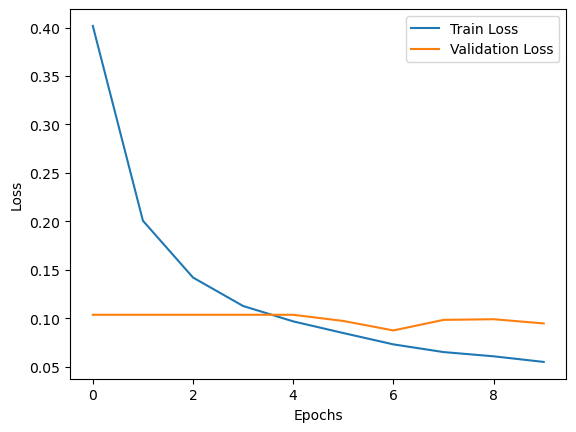

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
